Fútbol Match Highlights<br>
Recognize Target Player - Capstone 2<br>
Tom Widdows

This notebook retrieves the faces previouly extracted from the source images and attemps to recognize the faces utilizing the Target Face Recognizer Model we created earlier.<br><br>

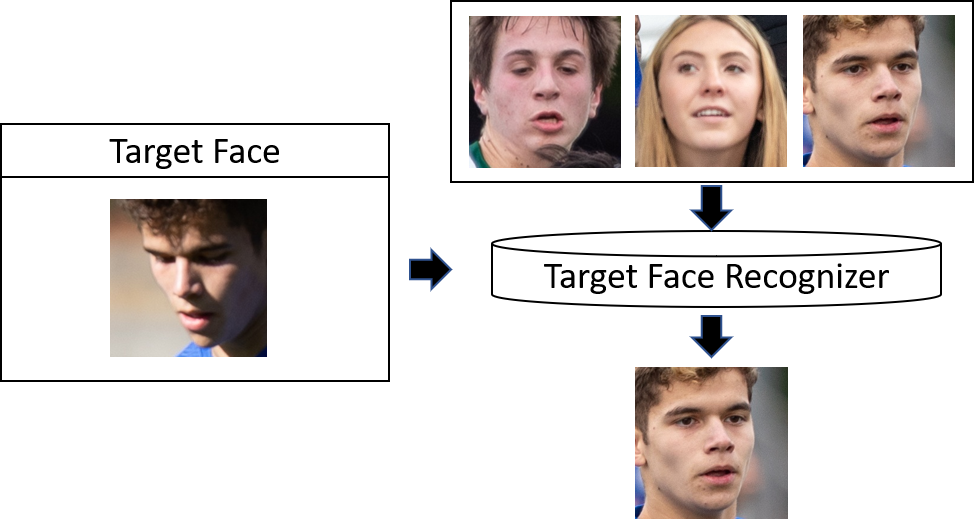

##### Housekeeping...

In [1]:
import sys
sys.path.append('../../code')
import settings as s

import cv2
from mtcnn import MTCNN
import numpy as np 
import pandas as pd 
from pathlib import Path
import pickle
import random
import shutil
import time

from support_class import Fball, FaceAligner, time_it

start_all = time.time()  # track time for notebook to run

%matplotlib inline

Using TensorFlow backend.


##### Common variables and settings

In [2]:
# common variables used throughout the notebook


##### Load the recognizer model

In [3]:
recognizer = Fball.load_model('baseline_target_face_recognizer_model')
le = Fball.load_model('baseline_target_face_recognizer_label_encoding') 

##### Get files

In [4]:
face_pickle_files = [f_name for d_name in Path(s.SOURCE_jn / 'baseline').glob("*") for f_name in d_name.glob('mtcnn_faces/mtcnn_pickles/*') if d_name.is_dir() if f_name.is_file() if f_name.suffix=='.pkl']
face_jpg_files = [(f_name.parent.parent / f_name.name).with_suffix('.jpg') for f_name in face_pickle_files]
source_files = [(f_name.parent.parent / f_name.stem[0:-12]).with_suffix('.jpg') for f_name in face_jpg_files]
df = pd.DataFrame(zip(face_pickle_files, face_jpg_files, source_files), columns=['file','path','path_file'])
df.columns = ['face_pickle_files','face_jpg_files', 'source_files']

##### Load data

In [5]:
face_pkls = list(df['face_pickle_files'])
face_jpgs = list(df['face_jpg_files'])
source_files = list(df['source_files'])
vecs = []
vecs_jpgs = []
for i, face_pkl in enumerate(face_pkls):
    with open(face_pkl, 'rb') as handle:
        d = pickle.load(handle)
        if 'vec' in d:
            v = d['vec'][0]
            if v.size == 128:
                vecs.append(d['vec'][0])
                vecs_jpgs.append(face_jpgs[i])
            else:
                print(face_jpgs[i])
                raise ValueError('The 128d face code (vec) is the incorrect size in the above file')
        else:
            print(face_jpgs[i])
            raise ValueError('The 128d face code (vec) in not contained in the above file')

##### Recognize target player

In [6]:
def recognize_face(vecs):
    preds = recognizer.predict_proba(vecs)
    for i, pred in enumerate(preds):
        j = np.argmax(pred)
        proba = pred[j]
        name = le.classes_[j]
        s_proba = f'pct_{pred[1]*100:.0f}_'.zfill(3)
        target = (s.RECOGNIZE_RESULTS_jn / 'baseline'/ Path(s_proba +  str(face_jpgs[i].name)))
        missed_target = target.parent / 'missed' 
        missed_target.mkdir(parents=True, exist_ok=True)

        if  pred[1] > .50:  #j == 1 and
            shutil.copyfile(face_jpgs[i], target)
            target = (s.RECOGNIZE_RESULTS_jn) / 'baseline' / Path(s_proba +  str(source_files[i].name))
            shutil.copyfile(source_files[i], target)
        else:
            if str(source_files[i].name).startswith('t01'):
                shutil.copyfile(source_files[i], missed_target / source_files[i].name)
recognize_face(vecs)

In [7]:
print(f'{time.strftime("%H:%M:%S", time.gmtime(int(time.time() - start_all)))}')

00:00:00
